Use colab to predict a probability that the image is a dog (1 = dog, 0 = cat)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# CNN -- Cat and Dog

## Import Module

In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset
from torch.utils.data import ConcatDataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.models import *
from torchvision import transforms, datasets
from google.colab import files
import os
from torch.autograd import Variable
from PIL import Image
from pathlib import Path
import time
from sklearn.model_selection import train_test_split

## Load dataset
from kaggle：[Dogs vs. Cats Redux: Kernels Edition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data)

In [0]:
'''
設置路徑
'''
root= 'drive/My Drive/CatandDog/'
train_dir = root+'train'
test_dir = root+'test'
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

In [0]:
# test = pd.DataFrame({
#     'filename': train_files,
# })
# for x in (test['filename'].values):
#     if '(' in x:
#         print(x)
#         train_files.remove(x)

In [0]:
# test = pd.DataFrame({
#     'filename': test_files,
# })
# for x in (test['filename'].values):
#     if '(' in x:
#         print(x)
#         test_files.remove(x)

In [7]:
print(len(train_files))
print(len(test_files))

25000
12500


In [8]:
'''
根據檔名判斷是 dog 或 cat
將 dog 標記類別為 1，cat 則是 0
'''
# 類別標註
categories = []
for filename in train_files:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

# 建立 dataframe
df = pd.DataFrame({
    'filename': train_files,
    'category': categories
})

df[:10]

,filename,category
0,dog.9118.jpg,1
1,dog.9119.jpg,1
2,dog.9115.jpg,1
3,dog.9117.jpg,1
4,dog.912.jpg,1
5,dog.9121.jpg,1
6,dog.9120.jpg,1
7,dog.9123.jpg,1
8,dog.9126.jpg,1
9,dog.9125.jpg,1


In [9]:
df[:10]

,filename,category
0,dog.9118.jpg,1
1,dog.9119.jpg,1
2,dog.9115.jpg,1
3,dog.9117.jpg,1
4,dog.912.jpg,1
5,dog.9121.jpg,1
6,dog.9120.jpg,1
7,dog.9123.jpg,1
8,dog.9126.jpg,1
9,dog.9125.jpg,1


## Train / Test Split

In [0]:

train_df, validate_df = train_test_split(df, test_size=0.10, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

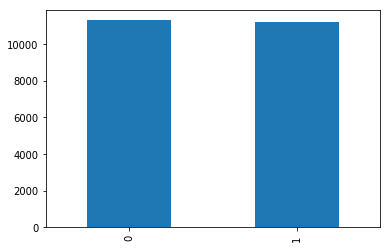

In [11]:
train_df['category'].value_counts().plot.bar()

In [12]:
len(validate_df)

2500

## Data Loading and Preprocessing

### Design a Dataset Class for Constructing a Dataset Object

In [0]:
'''
##### 建立資料集:
    dir: 資料路徑
    mode: 區分資料集類型(train/val/test)
    transform: 圖片轉換
    file_list: 圖片檔名
    label: 圖片類別
'''
class CatDogDataset(Dataset):
    def __init__(self, file_list, dir, mode='train', transform = None):
        self.dir = dir
        self.mode = mode
        self.transform = transform
        # 只有訓練集和驗證集有類別
        if (self.mode == 'train') or (self.mode == 'val'):
            self.file_list = list(file_list['filename'])
            self.label = list(file_list['category'])
        else:
            self.file_list = file_list
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        # 開啟圖片
        img = Image.open(os.path.join(self.dir, self.file_list[index]))
        
        # 設置圖片轉換
        if self.transform:
            img = self.transform(img)
        # 訓練集和驗證集回傳資料及類別
        if (self.mode == 'train') or (self.mode == 'val'):
            img = img.numpy()
            return img.astype('float32'), self.label[index]
        # 測試集則是回傳資料與圖片檔名
        else:
            img = img.numpy()
            return img.astype('float32'), self.file_list[index]

'''
##### 圖片轉換:
    Resize: 重置圖片大小
    CenterCrop: 依據給定的 size 從中心裁剪
    RandomRotation: 隨機旋轉
    RandomHorizontalFlip: 隨機水平翻轉
    ToTensor: 像素轉換成 tensor
'''
# train
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),

])

# val/test
test_transform = transforms.Compose([
    transforms.Resize(256), 
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

'''
資料放進 dataset
'''
train_dataset = CatDogDataset(train_df, train_dir, mode='train', transform = data_transform)
val_dataset = CatDogDataset(validate_df, train_dir, mode='val', transform = test_transform)
test_dataset = CatDogDataset(test_files, test_dir, mode='test', transform = test_transform)

### Use the `DataLoader` Object to Load Data

In [0]:
BATCH_SIZE = 32
'''
使用 DataLoader 將 dataset 包起來
'''
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle=False, num_workers=4,  drop_last=True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=False, num_workers=4)

## Convolution Neural Network

### Building CNN Model

>### 參考資料
>
> [early stop](https://github.com/Bjarten/early-stopping-pytorch)
>
> [early stop example](https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb)
>


In [15]:
'''
Pre-trained model: resnet152
'''
model = resnet152(pretrained=True)

# input 數量
num_ftrs = model.fc.in_features
# 目的是凍結參數，即使發生新的訓練也不會進行參數的更新
# 如果電腦硬體很棒，可以把這兩行註解直接訓練整個網路
for parma in model.parameters():
    parma.requires_grad = False 

# 建立 classifier
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 2),
    nn.Softmax(dim=1)
)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 241530880/241530880 [00:03<00:00, 70955772.12it/s]


### View the Pictures

>### 參考資料
>
> [ResNet152](https://zhuanlan.zhihu.com/p/44022834)
>
> [Transfer Learning in pytorch using Resnet18](https://www.kaggle.com/pintu161/transfer-learning-in-pytorch-using-resnet18)
>
> [Cats&Dogs_Classification](https://www.kaggle.com/lcc1106/cats-dogs-classification) 
> 

In [16]:
samples, labels = iter(val_loader).next()
fig = plt.figure(figsize=(24, 16))
fig.tight_layout()

# tensor 形式的轉換，將若干圖像轉成一張圖
grid_imgs = make_grid(samples, nrow=8, padding=5)
np_grid_imgs = grid_imgs.numpy()

# 圖片原本是 (batch, width, height) 要轉換成 (width, height, batch)
plt.axis('off') # 是否需要座標尺
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

Output hidden; open in https://colab.research.google.com to view.


### Training and Validation

使用別人寫好的 earlystop，當 val loss 超過 N 個 epochs 都沒有下降時就停止

此為將 pytorchtools.py 上傳至 colab

因為存在程式碼問題，固將原本的 delta 參數刪除

In [0]:
from pytorchtools import EarlyStopping

In [18]:
model = model.cuda()
'''
設 Optimizer 與 Cost Function
'''
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.005)
# learning rate 衰減
# patience 個 epochs 後，loss 沒有下降 lr 就降低為 factor * lr
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, min_lr=0.00001)

EPOCH = 10
train_losses = list() # 記錄所有訓練資料的 loss
val_losses = list() # 記錄所有的驗證資料 loss
avg_train_losses = list() # 平均訓練的 loss
avg_valid_losses = list() # 平均驗證的 loss
'''
訓練模型
'''
print("-----------------------訓練資料--------------------------------")
# 計算訓練時間
since = time.time()

# 最高的正確率
best_acc = 0.0

# patience 個 epoch 後，loss 沒下降就停止
early_stopping = EarlyStopping(patience=10, verbose=True)
for epoch in range(EPOCH):
    val_acc = 0
    print('現在的 learning rate: ', optimizer.param_groups[0]['lr'])
    # 訓練模式
    model.train()
    for index, (feature, label) in enumerate(train_loader): 
        # 有 Variable 才能做 Back Propagation
        # 也要記得把資料都丟進 GPU (如果模型使用 GPU)
        feature = Variable(feature).cuda()
        label = Variable(label).cuda()

        # 下一次訓練的時候先把前次的梯度清空
        optimizer.zero_grad()
        # 預測值
        outputs = model(feature)
        # 計算誤差
        loss = criterion(outputs, label)
        # Back Propagation
        loss.backward()
        # 更新 gradients
        optimizer.step()
        # 記錄 loss
        train_losses.append(loss.item())
        if (index+1) % 700 == 0:
            # 預測正確的有幾個
            correct = torch.sum(torch.argmax(outputs,dim=1)==label)
            print ('Epoch: [%d/%d], Batch: [%d/%d], Loss: %.20f, Accuracy: %.6f'
                   % (epoch+1, EPOCH, index+1, len(train_dataset)/BATCH_SIZE, loss.item(), correct.item()/BATCH_SIZE))
            
    # print("-----------------------驗證資料--------------------------------")   
    # 切換到評估模式
    model.eval()      
    # 不需要進行 backward 所以也就不用計算梯度值
    with torch.no_grad():
        # 驗證資料
        for index, (feature, label) in enumerate (val_loader): 

            feature = Variable(feature).cuda()
            label = Variable(label).cuda()
            val_outputs = model(feature)
            loss = criterion(val_outputs, label)

            val_losses.append(loss.item())
            
            # 記錄正確率
            val_correct = torch.sum(torch.argmax(val_outputs,dim=1)==label)
            val_acc = val_correct.item()/BATCH_SIZE
            if val_acc > best_acc:
                best_acc = val_acc

        # 記錄平均的 loss
        train_loss = np.average(train_losses)
        val_loss = np.average(val_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(val_loss)

        print('目前的 train loss: {:.5f} val loss: {:.5f}'.format(train_loss, val_loss))
        
        # 每個 epoch 記錄完後清除
        train_losses = []
        valid_losses = []

        # early stop
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stop")
            break
            
    # 根據條件衰減 learning rate
    scheduler.step(val_loss)


time_elapsed = time.time() - since
print('訓練時間 {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('驗證資料正確率最高為:  {:.4f}'.format(best_acc))

-----------------------訓練資料--------------------------------
現在的 learning rate:  0.001
Epoch: [1/10], Batch: [700/703], Loss: 0.34310913085937500000, Accuracy: 0.968750
目前的 train loss: 0.35524 val loss: 0.33161
Validation loss decreased (inf --> 0.331608).  Saving model ...
現在的 learning rate:  0.001
Epoch: [2/10], Batch: [700/703], Loss: 0.33978769183158874512, Accuracy: 0.968750
目前的 train loss: 0.34369 val loss: 0.33209
EarlyStopping counter: 1 out of 10
現在的 learning rate:  0.001
Epoch: [3/10], Batch: [700/703], Loss: 0.34301656484603881836, Accuracy: 0.968750
目前的 train loss: 0.34305 val loss: 0.33191
EarlyStopping counter: 2 out of 10
現在的 learning rate:  0.001
Epoch: [4/10], Batch: [700/703], Loss: 0.34285414218902587891, Accuracy: 0.968750
目前的 train loss: 0.34166 val loss: 0.33189
EarlyStopping counter: 3 out of 10
現在的 learning rate:  0.0005
Epoch: [5/10], Batch: [700/703], Loss: 0.33067515492439270020, Accuracy: 1.000000
目前的 train loss: 0.33905 val loss: 0.33180
EarlyStopping counte

### Training Process

>### 參考資料
>
> [調整學習率](https://www.cnblogs.com/wanghui-garcia/p/10895397.html)
> 

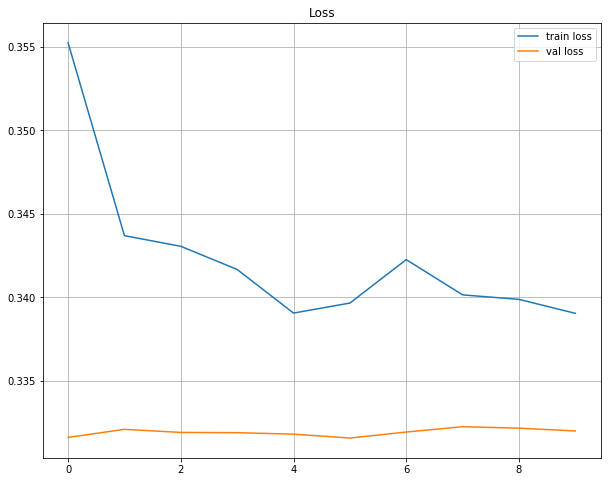

In [19]:
# 以視覺化方式檢視訓練過程
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,8))
plt.plot(range(len(avg_train_losses)), avg_train_losses, label="train loss")
plt.plot(range(len(avg_valid_losses)), avg_valid_losses, label="val loss")

plt.grid(True)
plt.legend()
plt.title("Loss")
plt.show()

In [20]:
'''
驗證資料預測
'''
model.eval()

pred_list = []
label_list = []
for index, (feature, label) in enumerate (val_loader):
    with torch.no_grad():

        output = model(feature.cuda())
        pred = torch.argmax(output, dim=1)
        pred_list += [p.item() for p in pred] 
        label_list += [l for l in label]

pred = np.asarray(pred_list).astype(int)

print('預測值：',  pred)

預測值： [1 0 1 ... 1 0 0]


### Evaluation

In [21]:
'''
承上預測資料範例
'''
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn import metrics
from sklearn.metrics import confusion_matrix

test = np.asarray(label_list).astype(int)
# print('實際值：', test)

'''
正確率
'''
accuracy = accuracy_score(test, pred)
print('Accuracy：', accuracy)

'''
AUC
'''
fpr, tpr, _ = metrics.roc_curve(pred, test)
auc = auc(fpr, tpr)
print('AUC：', auc)

'''
Confusion Matrix 與 各實際值與預測值的關係
'''
cm = confusion_matrix(test, pred)
print('Confusion Matrix： \n', cm)

TN, FP, FN, TP = confusion_matrix(test, pred).ravel()
print(TN, FP, FN, TP)

Accuracy： 0.985176282051282
AUC： 0.9852871687756634
Confusion Matrix： 
 [[1189   23]
 [  14 1270]]
1189 23 14 1270


### Ploting Confusion Matrix

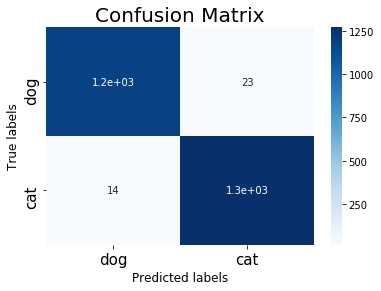

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt    

def plot_confusion_matrix(y_true, y_pred, classes, count, cmap=plt.cm.Blues):
    
    ax = plt.subplot()
    # heatmap 常⽤於呈現變數間的相關性，或用於呈現不同條件下，數量的高低關係
    sns.heatmap(count, annot = True, ax = ax, cmap = cmap);    # matplotlib 也有 heatmap

    # 設定各種標籤、標題
    ax.set_xlabel('Predicted labels',fontsize=12)
    ax.set_ylabel('True labels',fontsize=12) 
    ax.set_title('Confusion Matrix',fontsize=20) 
    ax.xaxis.set_ticklabels(classes,fontsize=15)  
    ax.yaxis.set_ticklabels(classes,fontsize=15)

classes = ["dog","cat"]
plot_confusion_matrix(test, pred, classes, cm)


In [0]:
# model = torch.load('checkpoint.pt')

In [31]:
model.eval()

filename_list = []
pred_list = []
for feature, filename in test_loader:
    with torch.no_grad():

        output = model(feature.cuda())
        #pred = torch.argmax(output, dim=1)
        filename_list += [int(fn.split('.')[0]) for fn in filename]
        pred_list += [p.item() for p in output[:,1]] # 也可以是 output[:,1] 就會是屬於狗的機率

submission = pd.DataFrame({"id":filename_list, "label":pred_list})
submission =  submission.sort_values(by=['id'], ascending=True).reset_index(drop=True)

submission

,id,label
0,1,0.999299
1,2,0.999979
2,3,0.999768
3,4,0.999978
4,5,0.000331
5,6,0.000001
6,7,0.000064
7,8,0.000137
8,9,0.000094
9,10,0.000107


In [0]:
submission.to_csv('Result.csv', index=False)

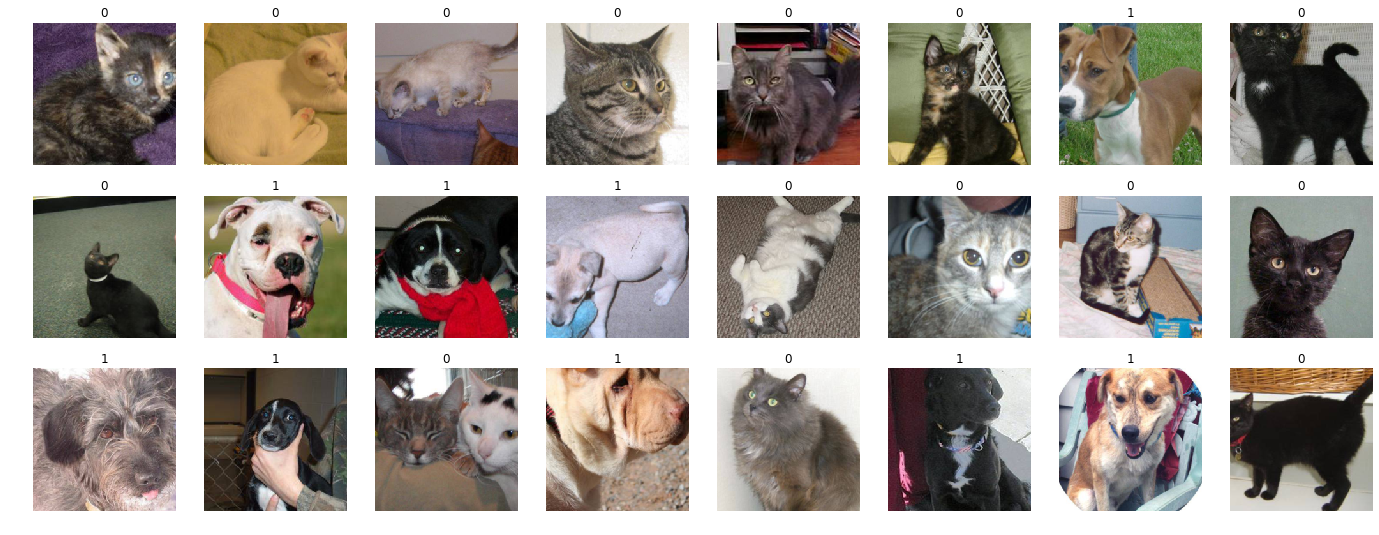

In [26]:
samples, _ = iter(test_loader).next()
fig = plt.figure(figsize=(24, 9))
fig.tight_layout()
output = model(samples[:24].cuda())
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]

for num, sample in enumerate(samples[:24]):
    plt.subplot(3,8,num+1)
    plt.title(pred[num])
    plt.axis('off')
    sample = sample.cpu().numpy()
    # 圖片原本是 (batch, width, height) 要轉換成 (width, height, batch)
    plt.imshow(np.transpose(sample, (1,2,0)))


Reference：https://www.kaggle.com/pintu161/transfer-learning-in-pytorch-using-resnet18